# Graph of words and keywords extraction

This notebook is dedicated to people who want to **extract keywords** from text document or corpus documents using a **graph approach**.

The goal of this notebook is to extract keywords from a text file using four different approachs :
- Best Coverage keywords extraction - http://www2013.w3c.br/proceedings/p715.pdf
- Div Rank keywords extraction - http://clair.si.umich.edu/~radev/papers/SIGKDD2010.pdf
- K-core Number 
- K-truss Number - https://arxiv.org/abs/1205.6693

----

We optimized the number of keywords to extract with inflexion and density methods -  https://www.aclweb.org/anthology/D16-1191

The parameters that can be modify are about :
- The type and choice of libraries for tokennization (NLTK, Spacy, StanfordNLP), the stopword list, the effectiveness of the steaming
- The type of graph (directed or not, weighted or not)
- The type of data (a graph for a text or for a corpus)

You need more explanations about the the textacy library ? https://media.readthedocs.org/pdf/textacy/latest/textacy.pdf

----
## Introduction
---

Here are the following steps : 
- Preprocess the text (nltk, spacy) - clean_text_simple_by_sents
- Create the input for the K-core algorithm - terms_to_graph_sents 
- Develop the K-core algorithm (networkx)
- Plot the entire graph and the best subgraph 
- Compare the keywords extraction methods 

Variables : 
- The path of your text file has to be set in "filename" (a list of strings)
- The number of keywords to extract have to be indicate in "nb_keys_terms_needed" 
- Many other parameters can be modified in the notebook

In [1]:
filename='/Users/newuser/Documents/LILI/EvoHDP_code/Test_GOT/txt_GOT/GoTS06E07_L_Homme_brisé.txt'
nb_keys_terms_needed=50

In [2]:
import networkx as nx
import re 
import itertools
import operator
import copy
import heapq
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
import string
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from networkx import k_core
from networkx import core_number
import spacy
import sys
import numpy as np
import textacy
from nltk.tokenize import word_tokenize,wordpunct_tokenize
import networkx.drawing
import textacy.keyterms
from networkx import common_neighbors
import pandas as pd
from collections import OrderedDict

nlp = spacy.load('fr')

In [3]:
stop_words=['à','soudain','presque', 'ensuite','l','bold_color','color_','italic_color_''d','s','de','un', 'une','alors','au','aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces','ceux','chaque','ci','comme','comment','dans','des','du','dedans','dehors'
    ,'depuis','devrait','doit','donc','dos','début','elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il','ils','je','juste'
    ,'la','le','les','leur','là','ma','maintenant','mais','mes','mine','moins','mon','mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas','peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement'
    ,'si','sien','son','sont','sous','soyez','sujet','sur','ta','tandis','tellement','tels','tes','ton','tous','tout','trop','très','tu','voient','vont','votre','vous','vu','ça','étaient','état','étions','été','être',"a","abord","absolument","afin","ah","ai","aie","aient","aies"
    ,"ailleurs","ainsi","ait","allaient","allo","allons","allô","alors","anterieur","anterieure","anterieures","apres","après","as","assez","attendu","au","aucun","aucune","aucuns","aujourd","aujourd'hui","aupres","auquel","aura","aurai","auraient","aurais","aurait","auras"
    ,"aurez","auriez","aurions","aurons","auront","aussi","autre","autrefois","autrement","autres","autrui","aux","auxquelles","auxquels","avaient","avais","avait","avant","avec","avez","aviez","avions","avoir","avons","ayant","ayez","ayons","b","bah","bas","basee","bat"
    ,"beau","beaucoup","bien","bon","boum","bravo","brrr","c","car","ce","ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci","celui-là","celà","cent","cependant","certain","certaine","certaines","certains","certes","ces","cet"
    ,"cette","ceux","ceux-ci","ceux-là","chacun","chacune","chaque","cher","chers","chez","chiche","chut","chère","chères","ci","cinq","cinquantaine","cinquantième","cinquième","clac","clic","combien","comme","comment","comparable","comparables","compris","concernant"
    ,"contre","couic","crac","d","dans","de","debout","dedans","dehors","deja","delà","depuis","dernier","derniere","derriere","derrière","des","desormais","desquelles","desquels","dessous","dessus","deux","deuxième","deuxièmement","devant","devers","devra","devrait","different"
    ,"differentes","differents","différent","différente","différentes","différents","dire","directe","directement","dit","dite","dits","divers","diverse","diverses","dix","dix-huit","dix-neuf","dix-sept","dixième","doit","doivent","donc","dont","dos","douze","douzième","dring","droite"
    ,"du","duquel","durant","dès","début","désormais","e","effet","egale","egalement","egales","eh","elle","elle-même","elles","elles-mêmes","en","encore","enfin","entre","envers","environ","es","essai","est","et","etant","etc","etre","eu","eue","eues","euh","eurent","eus","eusse"
    ,"eussent","eusses","eussiez","eussions","eut","eux","eux-mêmes","exactement","excepté","extenso","exterieur","eûmes","eût","eûtes","f","fais","faisaient","faisant","fait","faites","façon","feront","fi","flac","floc","fois","font","force","furent","fus","fusse","fussent","fusses","fussiez"
    ,"fussions","fut","fûmes","fût","fûtes","g","gens","h","ha","haut","hein","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","huit","huitième","hum","hurrah","hé","hélas"
    ,"i","ici","il","ils","importe","j","je","jusqu","jusque","juste","k","l","la","laisser","laquelle","las","le","lequel","les","lesquelles","lesquels","leur","leurs","longtemps","lors","lorsque","lui","lui-meme","lui-même","là","lès","m","ma","maint","maintenant","mais","malgre","malgré","maximale","me","meme","memes","merci","mes","mien","mienne","miennes","miens","mille","mince","mine","minimale","moi"
    ,"moi-meme","moi-même","moindres","moins","mon","mot","moyennant","multiple","multiples","même","mêmes","n","na","naturel","naturelle","naturelles","ne","neanmoins","necessaire","necessairement","neuf","neuvième","ni","nombreuses","nombreux","nommés","nos","notamment","notre","nous","nous-mêmes","nouveau","nouveaux","nul","néanmoins","nôtre","nôtres","o","oh","ohé","ollé","olé","on","ont","onze","onzième","ore","ou","ouf","ouias","oust","ouste","outre"
    ,"ouvert","ouverte","ouverts","o","où","p","paf","pan","par","parce","parfois","parle","parlent","parler","parmi","parole","parseme","partant","particulier","particulière","particulièrement"
    ,"pas","passé","pendant","pense","permet","personne","personnes","peu","peut","peuvent","peux","pff","pfft","pfut","pif","pire"
    ,"pièce","plein","plouf","plupart","plus","plusieurs","plutôt","possessif","possessifs","possible","possibles","pouah","pour","pourquoi","pourrais","pourrait","pouvait","prealable","precisement","premier","première","premièrement","pres","probable","probante","procedant","proche","près","psitt","pu","puis","puisque","pur","pure","q","qu"
    ,"quand","quant","quant-à-soi","quanta","quarante","quatorze","quatre","quatre-vingt","quatrième"
    ,"quatrièmement","que","quel","quelconque","quelle","quelles","quelqu'un","quelque","quelques","quels","qui","quiconque","quinze","quoi","quoique","r","rare","rarement","rares","relative","relativement","remarquable","rend","rendre","restant","reste","restent","restrictif","retour","revoici","revoilà","rien","s","sa","sacrebleu","sait","sans","sapristi"
    ,"sauf","se","sein","seize","selon","semblable","semblaient","semble","semblent","sent","sept","septième","sera","serai","seraient","serais","serait","seras","serez","seriez","serions","serons","seront","ses","seul","seule","seulement","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soient","sois","soit","soixante","sommes","son","sont","sous"
    ,"souvent","soyez","soyons","specifique","specifiques","speculatif","stop","strictement","subtiles","suffisant","suffisante","suffit","suis","suit","suivant","suivante","suivantes","suivants","suivre","sujet","superpose","sur","surtout","t","ta","tac","tandis","tant","tardive","te","tel","telle","tellement","telles","tels","tenant","tend","tenir","tente","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant"
    ,"toujours","tous","tout","toute","toutefois","toutes","treize","trente","tres","trois","troisième","troisièmement","trop","très","tsoin","tsouin","tu","té","u","un","une","unes","uniformement","unique","uniques","uns","v","va","vais","valeur","vas","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan"
    ,"voici","voie","voient","voilà","vont","vos","votre","vous","vous-mêmes","vu","vé","vôtre","vôtres","«",""
    ,"w","x","y","z","zut","à","â","ça","ès","étaient","étais","était","étant","état","étiez","étions","été","étée","étées","étés","êtes","être","ô"]

------
## Preprocess the text (nltk, spacy)
------

In [4]:
doc=open(filename,'r')
text=doc.read()
doc.close()
print(text)

À Port-Réal, Margaery s’entretient avec le Grand Moineau et semble totalement sous l’emprise de la Foi. Celui-ci la met en garde sur l’influence néfaste de sa grand-mère qui doit selon lui se repentir de ses péchés. Revenue au Donjon Rouge, la jeune reine, accompagnée de Septa Unella, confronte Olenna en lui demandant froidement de retourner à Hautjardin, tout en lui donnant discrètement un message du coin de sa robe. Olenna accepte de partir puis, dans le couloir, sourit en voyant une rose, le symbole de la Maison Tyrell, dessinée sur le parchemin : Margaery mène en réalité un double jeu contre le Grand Moineau. Olenna est ensuite confrontée à Cersei qui désire prolonger leur trêve afin de sauver Tommen. Olenna lui conseille de partir comme elle, vu que la Reine-Mère n’a plus aucun allié dans la capitale, et ne peut s’empêcher de lui dire que le malheur de Cersei, seule responsable de la situation, constitue bien pour elle son seul lot de consolation.

À Braavos, Arya soudoie un marin

In [10]:
def txt_to_sentences(file_title):
    with open(file_title, "r") as text:
        text = str(text.read())
        text=text.lower()
        text=textacy.preprocess.normalize_whitespace(text)
        text=textacy.preprocess.fix_bad_unicode(text, normalization=u'NFKC')
        text=textacy.preprocess.preprocess_text(text, fix_unicode=False, lowercase=False, transliterate=False, no_urls=False,no_phone_numbers=False,no_currency_symbols=False,
        no_emails=True, no_numbers=False, no_punct=False,no_contractions=False, no_accents=False)
        text=textacy.preprocess.unpack_contractions(text)
        nlp_text=textacy.Doc(text).pos_tagged_text
        return(nlp_text)
txt_sentences=txt_to_sentences(filename)
txt_sentences[:1]

[[('à', 'ADP'),
  ('port-réal', 'NOUN'),
  (',', 'PUNCT'),
  ('margaery', 'NOUN'),
  ("s'", 'PRON'),
  ('entretient', 'VERB'),
  ('avec', 'ADP'),
  ('le', 'DET'),
  ('grand', 'ADJ'),
  ('moineau', 'NOUN'),
  ('et', 'CCONJ'),
  ('semble', 'VERB'),
  ('totalement', 'ADV'),
  ('sous', 'ADP'),
  ("l'", 'DET'),
  ('emprise', 'NOUN'),
  ('de', 'ADP'),
  ('la', 'DET'),
  ('foi', 'NOUN'),
  ('.', 'PUNCT')]]

In [49]:
def clean_text_simple_by_sents(tok_sent_tagged, my_stopwords, remove_stopwords=True, pos_filtering=True, stemming=True):
    cleaned_text=[]
    for i,phrase in enumerate(tok_sent_tagged):
        tokens=[]
        for words in enumerate(phrase):
            if pos_filtering == True:
                if (words[1][1] == 'NOUN' or words[1][1] == 'ADJ'):
                    tokens.append(words[1][0])
            else:
                tokens.append(words[1][0])   
        if remove_stopwords:
            tokens = [token for token in tokens if token not in my_stopwords]
        if stemming:
            # apply Porter's stemmer
            stemmer = nltk.stem.PorterStemmer()
            tokens_stemmed = list()
            for token in tokens:
                tokens_stemmed.append(stemmer.stem(token))
            tokens = tokens_stemmed
        cleaned_text.append(tokens)
    return(cleaned_text)

clean_txt_sents=clean_text_simple_by_sents(txt_sentences, stop_words,remove_stopwords=True, pos_filtering=True, stemming=False)
clean_txt_sents[1:3]

[['met', 'garde', 'influence', 'néfaste', 'grand-mère', 'péchés'],
 ['donjon',
  'rouge',
  'jeune',
  'reine',
  'septa',
  'unella',
  'confronte',
  'hautjardin',
  'message',
  'coin',
  'robe']]

------
## Create the input for the K-core algorithm
------

In [50]:
def terms_to_graph_sents(clean_txt_sents, w,stopping_end_of_line=0):
    from_to = {}
    if(not stopping_end_of_line):
        extended_clean_txt_sents=[]
        for sublist in clean_txt_sents:
            extended_clean_txt_sents.extend(sublist)
        clean_txt_sents=[extended_clean_txt_sents]
    for k,sents in enumerate(clean_txt_sents):
        len_sents=len(sents)

        # create initial complete graph (first w terms)
        terms_temp = sents[0:min(w,len_sents)]
        indexes = list(itertools.combinations(range(min(w,len_sents)), r=2))
        new_edges = []
        for my_tuple in indexes:
            new_edges.append(tuple([terms_temp[i] for i in my_tuple]))

        for new_edge in new_edges:
            if new_edge in from_to:
                from_to[new_edge] += 1
            else:
                from_to[new_edge] = 1

        if(w<=len_sents):
            # then iterate over the remaining terms
            for i in range(w, len_sents):
                considered_term = sents[i] # term to consider
                terms_temp = sents[(i-w+1):(i+1)] # all terms within sliding window

                # edges to try
                candidate_edges = []
                for p in range(w-1):
                    candidate_edges.append((terms_temp[p],considered_term))

                for try_edge in candidate_edges:

                    if try_edge[1] != try_edge[0]:
                    # if not self-edge

                        # if edge has already been seen, update its weight
                        if try_edge in from_to:
                            from_to[try_edge] += 1

                        # if edge has never been seen, create it and assign it a unit weight     
                        else:
                            from_to[try_edge] = 1
    
    return(from_to)

tuples_words_sents_unweighted=list(terms_to_graph_sents(clean_txt_sents, w=5,stopping_end_of_line=1).keys())
tuples_words_sents_weighted=terms_to_graph_sents(clean_txt_sents, w=5,stopping_end_of_line=0)

print("tuples unweighted \n")
tuples_words_sents_unweighted[:10]

tuples unweighted 



[('port-réal', 'margaery'),
 ('port-réal', 'grand'),
 ('port-réal', 'moineau'),
 ('port-réal', 'emprise'),
 ('margaery', 'grand'),
 ('margaery', 'moineau'),
 ('margaery', 'emprise'),
 ('grand', 'moineau'),
 ('grand', 'emprise'),
 ('moineau', 'emprise')]

In [31]:
nb_iter=0
print("tuples weighted \n")
for key in tuples_words_sents_weighted.keys():
    if(nb_iter <10):
        nb_iter+=1
        print(key,tuples_words_sents_weighted[key])

tuples weighted 

('port-réal', 'margaery') 1
('port-réal', 'grand') 1
('port-réal', 'moineau') 1
('port-réal', 'emprise') 1
('margaery', 'grand') 2
('margaery', 'moineau') 1
('margaery', 'emprise') 1
('grand', 'moineau') 2
('grand', 'emprise') 1
('moineau', 'emprise') 1


------
## Networkx examples before comparison
------

In [51]:
## UNWEIGHTED AND WEIGHTED GRAPH 
def unweighted_graph(tuples_words_sents_unweighted):
    G = nx.Graph()
    G.add_edges_from(tuples_words_sents_unweighted)
    return(G)

G_unweighted=unweighted_graph(tuples_words_sents_unweighted)

def weighted_graph(tuples_words_sents_weighted):
    G = nx.Graph()
    for keys,values in tuples_words_sents_weighted.items():
        G.add_edge(keys[0],keys[1],weight=values)
    return(G)

G_weighted=weighted_graph(tuples_words_sents_weighted)

In [52]:
## Generate and order a list of best keywords, the number is specified by "nb_keys_terms_needed"
G_Unweighted_core_number=core_number(G_unweighted)
G_Weighted_core_number=core_number(G_weighted)

def order_dict_best_keywords(G_core_number,nb_keys_terms_needed=10):
    k_core_keyTerms=sorted(G_core_number, key=G_core_number.get, reverse=True)
    Kcore_values=[G_core_number[x] for x in k_core_keyTerms[:nb_keys_terms_needed]]
    return(k_core_keyTerms,Kcore_values)

UW_k_core_keyTerms,UW_Kcore_values=order_dict_best_keywords(G_Unweighted_core_number,nb_keys_terms_needed)
W_k_core_keyTerms,W_Kcore_values=order_dict_best_keywords(G_Weighted_core_number,nb_keys_terms_needed)

------
## Plot the entire graph and the best subgraph 
------

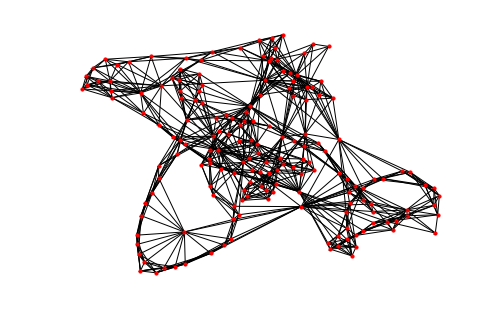

In [53]:
## WEIGHTED 
nx.draw(G_weighted, with_labels=True,font_size=0.02,width=1,node_size=10,label='Graph Unweighted GOT')
plt.show()

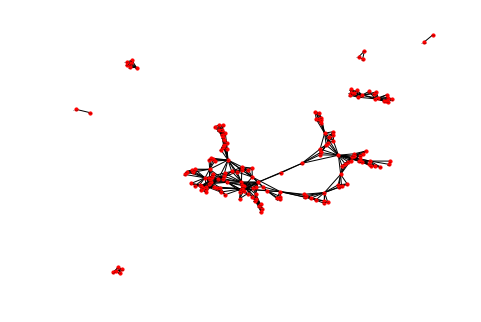

In [54]:
## UNWEIGHTED
nx.draw(G_unweighted, with_labels=True,font_size=0.02,width=1,node_size=10,label='Graph Unweighted GOT')
plt.show()

----
### Example of 5-core subgraph
----

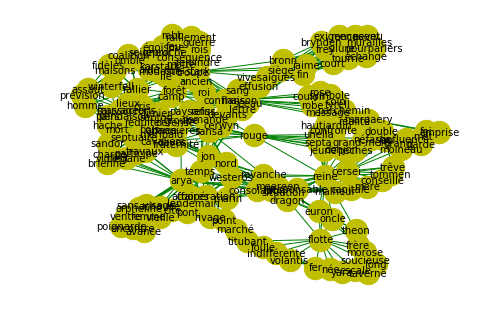

In [55]:
subgraph_k_core=k_core(G_weighted, k=5 ,core_number=None)
nx.draw(subgraph_k_core, with_labels=True,node_color='y',edge_color='g',font_size=10,width=1,node_size=500,label='Graph Unweighted GOT')
plt.show()
plt.savefig("subrgraph_kcore.png")

-----
## K-Truss
-----

**Definition of k_truss :**

- K-truss is a triangle-based extension of k-core introduced by (Cohen, 2008). More precisely, the K-truss subgraph of G is its largest subgraph where ev- ery edge belongs to at least K − 2 triangles. In other words, every edge in the K-truss joins two vertices that have at least K − 2 common neighbors. Compared to k-core, K-truss thus does not iteratively prune nodes out based on the number of their direct links, but also based on the number of their shared connections. This more accurately captures cohesiveness.
- K-truss is calculated from the number of triangle each node has. Thus the weights do not change the results. Weighted and Unweighted graph will have the same k-truss

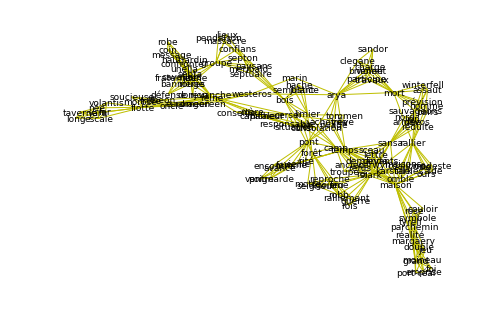

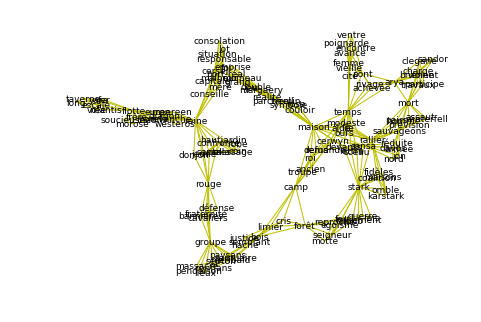

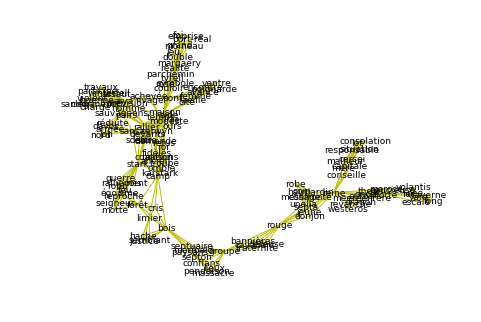

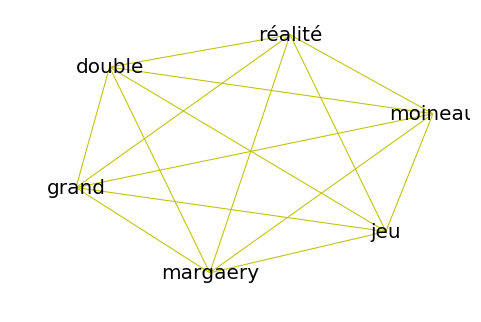

In [47]:
G=G_unweighted.copy()
def compute_sup_e(H):
    dict_res={}
    edges_sorted={}
    edges=H.edges
    for e in edges:
        edges_sorted[e]=len(list(common_neighbors(H, e[0], e[1])))
    edges_sorted=sorted(edges_sorted.items(), key=lambda x: x[1])
    return(OrderedDict(edges_sorted))

def dict_to_sorted_dict(dictionnary):
    return(OrderedDict(sorted(dictionnary.items(), key=lambda x: x[1])))
 
def k_truss_True_Dec_Massive_Net(G,output_for_density=True):
    edges_sorted=compute_sup_e(G)
    k_truss_nodes={}
    for node in G.nodes:
        k_truss_nodes[node]=0
    not_all_edges_removed=True
    edges_sorted=compute_sup_e(G)
    k=2
    liste_remove=[]
    output_density=[[k,len(G.nodes()),len(G.edges)]]
    while (not_all_edges_removed):
        liste_remove_k=[]
        while(list(edges_sorted.values())[0]<=k-2):
            e=list(edges_sorted.keys())[0]
            node1=list(edges_sorted.keys())[0][0]
            node2=list(edges_sorted.keys())[0][1]
            nb_u=G.neighbors(node1)
            nb_v=G.neighbors(node2)
            nbU=list(nb_v)
            u=node2
            v=node1
            if (len(list(nb_u))<len(list(nb_v))) :
                nbU=list(nb_u)
                u=node1
                v=node2
            for w in nbU:
                if(G.has_edge(w,v)):
                    sup_keys=edges_sorted.keys()
                    if((v,w) in sup_keys):
                        edges_sorted[(v,w)]-=1
                    else:
                        edges_sorted[(w,v)]-=1
                    if((u,w) in sup_keys):
                        edges_sorted[(u,w)]-=1
                    else:
                        edges_sorted[(w,u)]-=1
                    edges_sorted=dict_to_sorted_dict(edges_sorted)
            del(edges_sorted[e])
            liste_remove_k.append(e)
            G.remove_edge(e[0],e[1])
            if(len(G.edges)==0):
                break
        liste_remove.append(liste_remove_k)
        
        if(len(list(edges_sorted.keys()))==0):
            not_all_edges_removed=False
        else:
            k+=1            
            G_bis=max(nx.connected_component_subgraphs(G),key=len)
            for node_not_removed in G_bis.nodes:
                k_truss_nodes[node_not_removed]+=1
            if(output_for_density):
                output_density.append([k,len(list(G_bis.nodes)),len(G_bis.edges)]) 

            nx.draw(G_bis, with_labels=True,font_color='k',node_color='g',edge_color='y',font_size=max(min(20,500/len(G_bis.nodes)),9),width=1,node_size=0,label='Graph Unweighted GOT')
            #plt.figure(figsize=(15, 15))
            plt.savefig("Approach_3°{}.png".format(k-2))
            plt.show()
            
    return(k_truss_nodes,k,G_bis,output_density)
k_truss_nodes,k,G_bis,output_density=k_truss_True_Dec_Massive_Net(G,output_for_density=True)

### Checking K-truss code with synthetic data (see the articles mentionnent in the read_me)

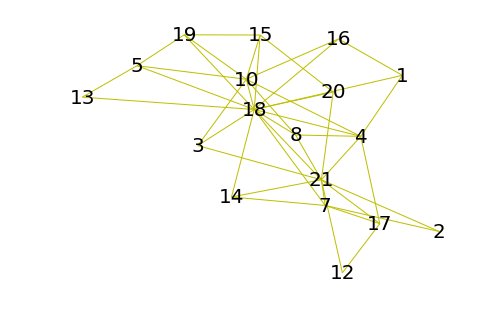

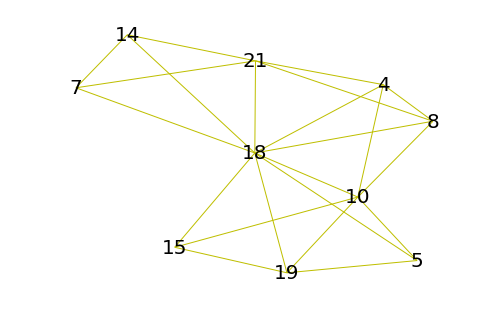

In [63]:
G=nx.Graph()
G.add_edges_from([(12,17),(12,21),(6,21),(4,17),(4,21),(3,21),(20,21),(15,10),(19,10),(19,18),(19,5),(19,15),(5,10),(4,1),
                  (4,18),(3,18),(20,18),
                 (15,18),(5,18),(5,13),(13,18),(4,8),(4,10),(3,10),(20,15),(15,19),(10,8),(10,16),(10,18),
                  (16,18),(16,1),(21,17),(21,2),(21,7),(18,1),(21,14),(21,18),(21,8),(17,7),(7,11),(2,7),(7,14),
                  (14,18),(7,18),(18,8),(9,18)])
k_truss_nodes,k,G_bis,output_density=k_truss_True_Dec_Massive_Net(G,output_for_density=True)

## Density method

In [71]:
def dens_function(output_density):
    D_n=[]
    for V_E in output_density:
        if(V_E[1]>1):
            D_n.append([V_E[0],V_E[2]/(V_E[1]*(V_E[1]-1))])
        else:
            D_n.append([V_E[0],0])
    return(D_n)

def elbow_function(D_n):
    if(len(D_n)>2):
        a_equation=(D_n[0][1]-D_n[-1][1])/(D_n[0][0]-D_n[-1][0])
        b_equation=(D_n[0][1]-D_n[0][0]*a_equation)
        distance={}
        s=0
        for (x,y) in D_n:
            distance[s]=(abs((a_equation*x+b_equation-y)/(((a_equation**2)+(1)))**(1/2)))
            s+=1
        distance=sorted(distance, key=distance.get, reverse=True)
        if(distance[0]!=distance[1]):
            return(distance[0])
        else:
            return(0)
    else:
        if(len(D_n)>2==1):
            return(D_n[0][0])
        else:
            return(max(D_n[0][0],D_n[1][0]))
        
def output_dens(G):
    D_n=[]
    k=0
    GG=k_core(G, k, core_number=None)
    D_n.append([k,len(GG.nodes),len(GG.edges)])
    while(len(GG.nodes)>0):
        k+=1
        GG=k_core(G, k, core_number=None)
        D_n.append([k,len(GG.nodes),len(GG.edges)])
    return(D_n)


## Density & Inflexion method

In [72]:
def get_optimized_nb_keywords(G,dens_methode,inf_method,k_core_meth):
    if(dens_methode and not(k_core_meth)):
        k_values_per_node,k,H2,output_density=K_truss(G.copy(),output_for_density=True)
        D_n=dens_function(output_density) 
        return(output_density[elbow_function(D_n)][1])
    
    elif(dens_methode and(k_core_meth)):
        output_density=output_dens(G)
        D_n=dens_function(output_density) 
        return(output_density[elbow_function(D_n)][1])
    
    elif(not dens_methode and not(k_core_meth)):
        k_values_per_node,k,H2,output_density=K_truss(G.copy(),output_for_density=True)
        CD=[]
        n=1
        for i in range(len(output_density)-1):
            CD.append(output_density[i+1][1]-output_density[i][1])
        for i in range(2,len(CD)-1):
            if(CD[i+1]<0 and CD[i]>0):
                n=i
        return(output_density[n][1])   

    else:
        output_density=output_dens(G)
        CD=[]
        n=1
        for i in range(len(output_density)-1):
            CD.append(output_density[i+1][1]-output_density[i][1])
        for i in range(2,len(CD)-1):
            if(CD[i+1]<0 and CD[i]>0):
                n=i
        return(output_density[n][1])    

------
## Compare the keywords extraction methods 
------

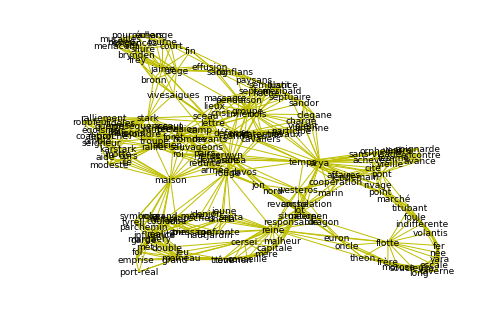

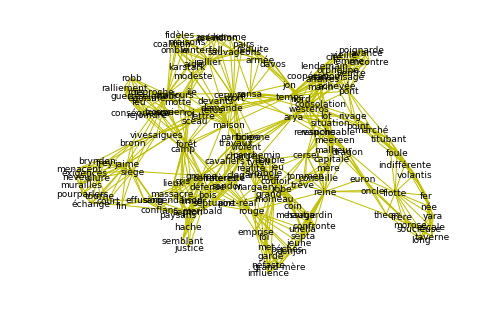

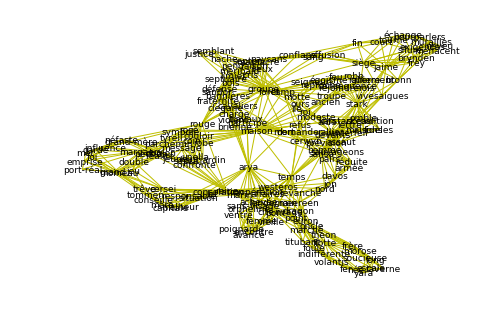

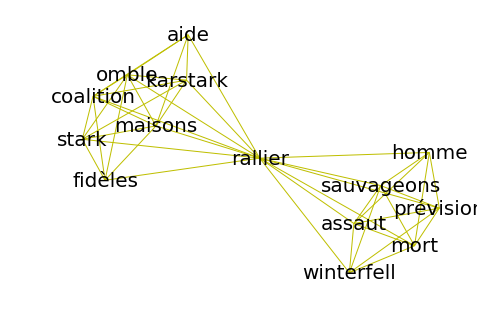

,Best_K_Core,Kcore_values,K_truss,K_truss_values,Div_Rank_KeyTerms,DR_values,Best_Coverage_KeyTerms,BC_values
0,margaery,7,sauvageons,4,reine,0.029986,maison,0.013456
1,grand,7,rallier,4,maison,0.026684,arya,0.013368
2,moineau,7,homme,4,arya,0.025959,reine,0.013214
3,emprise,7,mort,4,stark,0.024859,stark,0.012959
4,foi,7,prévision,4,groupe,0.019016,temps,0.012822
5,met,7,assaut,4,bois,0.016790,groupe,0.012680
6,garde,7,winterfell,4,temps,0.016110,bois,0.011388
7,influence,7,maisons,4,jaime,0.014895,rallier,0.011381
8,néfaste,7,fidèles,4,rallier,0.013821,jaime,0.010946
9,grand-mère,7,stark,4,flotte,0.011064,flotte,0.009762


In [73]:
def txt_to_keywords(filename,stopwords,window_size,nb_keywords=20,approach=3,weighted=True,end_of_line=True,dens_methode=True,inf_method=False,k_core_meth=True):
    txt_sentences=txt_to_sentences(filename)
    clean_txt_sents=clean_text_simple_by_sents(txt_sentences, stopwords,remove_stopwords=True, pos_filtering=True, stemming=False)
    
    if(weighted):
        tuples_words_sents=terms_to_graph_sents(clean_txt_sents, w=window_size,stopping_end_of_line=end_of_line)
        G=weighted_graph(tuples_words_sents)
        G_core_number=core_number(G)                                                    
    else:
        tuples_words_sents=list(terms_to_graph_sents(clean_txt_sents, w=5,stopping_end_of_line=end_of_line).keys())
        G=unweighted_graph(tuples_words_sents)
        
    if(dens_methode or inf_method):
        nb_keywords=get_optimized_nb_keywords(G,dens_methode,inf_method,k_core_meth)
        
    G_core_number=core_number(G)
    k_core_keyTerms,Kcore_values=order_dict_best_keywords(G_core_number,nb_keywords)
    

    k_values_per_node,k,H2,output_density=k_truss_True_Dec_Massive_Net(unweighted_graph(tuples_words_sents),output_for_density=True)
    
    KTruss_keyTerms,KTruss_values=order_dict_best_keywords(k_values_per_node,nb_keywords)  
    
    DivRank=textacy.keyterms.rank_nodes_by_divrank(G, r=None, lambda_=0.5, alpha=0.5)
    DivRank_keyTerms,DivRank_values=order_dict_best_keywords(DivRank,nb_keywords)
    
    BCoverage=textacy.keyterms.rank_nodes_by_bestcoverage(G, k=nb_keywords, c=1, alpha=1.0)
    BCoverage_keyTerms,BCoverage_values=order_dict_best_keywords(BCoverage,nb_keywords)
    
    df_results=pd.DataFrame(columns=['Best_K_Core','Kcore_values','K_truss','K_truss_values','Div_Rank_KeyTerms','DR_values','Best_Coverage_KeyTerms'
                                 ,'BC_values'])
    df_results['Best_K_Core']=k_core_keyTerms[:nb_keywords]
    df_results['Div_Rank_KeyTerms']=DivRank_keyTerms[:nb_keywords]
    df_results['Best_Coverage_KeyTerms']=BCoverage_keyTerms[:nb_keywords]
    df_results['Kcore_values']=Kcore_values[:nb_keywords]
    df_results['DR_values']=DivRank_values[:nb_keywords]
    df_results['BC_values']=BCoverage_values[:nb_keywords]
    df_results['K_truss']=KTruss_keyTerms[:nb_keywords]
    df_results['K_truss_values']=KTruss_values[:nb_keywords]
    
    return(df_results)


df_test=txt_to_keywords(filename,stop_words,window_size=3,nb_keywords=20,weighted=False,end_of_line=False,dens_methode=True,inf_method=False,k_core_meth=True)
df_test